In [2]:
from __future__ import division

import locale
import numpy as np
import scipy.io as sio
import scipy.sparse as ss
import scipy.spatial.distance as ssd
import itertools
import cPickle
import datetime
import collections
import hashlib
import matplotlib.pyplot as plt
import pycountry

from collections import defaultdict
from sklearn.preprocessing import normalize

In [108]:
class PreprocessData:
  """
  Converting strings to equivalent numbers
  or number buckets.
  """
  def __init__(self):
    
    # load locales
    self.localeIdMap = defaultdict(int)
    for i, l in enumerate(locale.locale_alias.keys()):
      self.localeIdMap[l] = i + 1  # self.localeIdMap["hu_hu"] = 37
    
    
    # load countries
    self.countryIdMap = defaultdict(int)
    countryIdx = defaultdict(int)
    for i, c in enumerate(pycountry.countries):
      self.countryIdMap[c.name.lower()] = i + 1
    
      if c.name.lower() == "usa":           # usa and canada user locations don't have the country name in data
        countryIdx["US"] = i
      if c.name.lower() == "canada":
        countryIdx["CA"] = i
        
    for cc in countryIdx.keys():           # if state is provided in location field, retrieve its country id
      for s in pycountry.subdivisions.get(country_code=cc):
        self.countryIdMap[s.name.lower()] = countryIdx[cc] + 1
  
    # load gender id map
    self.genderIdMap = defaultdict(int, {"male":1, "female":2})

  def getLocaleId(self, locstr):
    return self.localeIdMap[locstr.lower()]

  def getGenderId(self, genderStr):
    return self.genderIdMap[genderStr]

  def getJoinedYearMonth(self, dateString):      #  2012-10-02T06:40:55.524Z -> 201210
    dttm = datetime.datetime.strptime(dateString, "%Y-%m-%dT%H:%M:%S.%fZ")
    return "".join([str(dttm.year), str(dttm.month)])

  def getCountryId(self, location):
    if (isinstance(location, str)
        and len(location.strip()) > 0
        and location.rfind("  ") > -1):  
      return self.countryIdMap[location[location.rindex("  ") + 2:].lower()]  #location[first occurrence of "  " + 2 to end of string]
    else:
      return 0

  def getBirthYearInt(self, birthYear):
    try:
      return 0 if birthYear == "None" else int(birthYear)
    except:
      return 0

  def getTimezoneInt(self, timezone):
    try:
      return int(timezone)
    except:
      return 0

  def getFeatureHash(self, value):
    if len(value.strip()) == 0:
      return -1
    else:
      return int(hashlib.sha224(value).hexdigest()[0:4], 16)

  def getFloatValue(self, value):
    if len(value.strip()) == 0:
      return 0.0
    else:
      return float(value)

In [109]:

class ProgramEntities:
    def __init__(self):

        uniqueUsers = set()
        uniqueEvents = set()
        eventsForUser = defaultdict(set)
        usersForEvent = defaultdict(set)
        
        
        f = open("/users/chaitanya/PyCharmProjects/EventRec/data/train.csv", 'rb')
        f.readline().strip().split(",")
        for line in f:
            cols = line.strip().split(",")
            uniqueUsers.add(cols[0])
            uniqueEvents.add(cols[1])
            eventsForUser[cols[0]].add(cols[1])
            usersForEvent[cols[1]].add(cols[0])
        f.close()

            
        self.userEventScores = ss.dok_matrix((len(uniqueUsers), len(uniqueEvents)))
        self.userIndex = dict()
        self.eventIndex = dict()
        
        # Allot new sequential user and event ids
        for i, u in enumerate(uniqueUsers):
            self.userIndex[u] = i
        for i, e in enumerate(uniqueEvents):
            self.eventIndex[e] = i
            
        ftrain = open("/users/chaitanya/PyCharmProjects/EventRec/data/train.csv", 'rb')
        ftrain.readline()
        
        for line in ftrain:
            cols = line.strip().split(",")
            i = self.userIndex[cols[0]]
            j = self.eventIndex[cols[1]]
            self.userEventScores[i, j] = int(cols[4]) - int(cols[5])  #interested - not_interested = 0/1/-1
        ftrain.close()
        
        #self.userEventScores is (2034,8846) but its a very sparse matrix
        
        sio.mmwrite("/users/chaitanya/PyCharmProjects/EventRec/Models/PE_userEventScores", self.userEventScores)
            # find all unique user pairs and event pairs that we should
            # look at. These should be users who are linked via an event
            # or events that are linked via a user in either the training
            # or test sets. This is to avoid useless calculations
            
        self.uniqueUserPairs = set()
        self.uniqueEventPairs = set()
        
        for event in uniqueEvents:
            users = usersForEvent[event]
            if len(users) > 2:
                self.uniqueUserPairs.update(itertools.combinations(users, 2))
                
        for user in uniqueUsers:
            events = eventsForUser[user]
            if len(events) > 2:
                self.uniqueEventPairs.update(itertools.combinations(events, 2))
                
        #Serialize        
        cPickle.dump(self.userIndex, open("/users/chaitanya/PyCharmProjects/EventRec/Models/PE_userIndex.pkl", 'wb'))
        cPickle.dump(self.eventIndex, open("/users/chaitanya/PyCharmProjects/EventRec/Models/PE_eventIndex.pkl", 'wb'))


In [110]:
class Users:
  """
  Build the user/user similarity matrix for train users
  """
  def __init__(self, programEntities, sim=ssd.correlation):
        
    cleaner = PreprocessData()     # __init__ loads country, locale and gender map
    
    fin = open("/users/chaitanya/PyCharmProjects/EventRec/data/users.csv", 'rb')
    colnames = fin.readline().strip().split(",")   # First line contains the headers
    
    nusers = len(programEntities.userIndex.keys())
       
    self.userMatrix = ss.dok_matrix((nusers, len(colnames) - 1)) #Build matrix with nusers and colnames
    
    for line in fin:
      cols = line.strip().split(",")
      
      if programEntities.userIndex.has_key(cols[0]):   # Consider user only if he exists in train.csv
        
        i = programEntities.userIndex[cols[0]]   # Get user_id
        self.userMatrix[i, 0] = cleaner.getLocaleId(cols[1])
        self.userMatrix[i, 1] = cleaner.getBirthYearInt(cols[2])
        self.userMatrix[i, 2] = cleaner.getGenderId(cols[3])
        self.userMatrix[i, 3] = cleaner.getJoinedYearMonth(cols[4])
        self.userMatrix[i, 4] = cleaner.getCountryId(cols[5])
        self.userMatrix[i, 5] = cleaner.getTimezoneInt(cols[6])
        
    fin.close()
    
    # normalize the user matrix
    self.userMatrix = normalize(self.userMatrix, norm="l1", axis=0, copy=False)
    sio.mmwrite("/users/chaitanya/PyCharmProjects/EventRec/Models/US_userMatrix", self.userMatrix)
    
    # calculate the user similarity matrix and save it for later
    self.userSimMatrix = ss.dok_matrix((nusers, nusers))
    
    # Diagonal elements of Matrix = 1.0
    for i in range(0, nusers):
      self.userSimMatrix[i, i] = 1.0
    
    for u1, u2 in programEntities.uniqueUserPairs:
        
      i = programEntities.userIndex[u1]  # Retrieve sequential index
      j = programEntities.userIndex[u2]
        
      if not self.userSimMatrix.has_key((i, j)):
        # convert to dense arrays and calculate similarity
        usim = sim(self.userMatrix.getrow(i).todense(), self.userMatrix.getrow(j).todense())  
        
        self.userSimMatrix[i, j] = usim
        self.userSimMatrix[j, i] = usim
        
    sio.mmwrite("/users/chaitanya/PyCharmProjects/EventRec/Models/US_userSimMatrix", self.userSimMatrix)

In [111]:
class UserFriends:
  """
  Returns the friends of the specified user. 
  The idea is that 
  (a) people with more friends are more likely to attend
  events and 
  (b) if your friend is going, its more likely for
  you to go as well
  
  We will find a user-friend score depending on these metrics
  """
  def __init__(self, programEntities):
        
    nusers = len(programEntities.userIndex.keys())
    
    self.numFriends = np.zeros((nusers)) # Returns an array filled with zeroes of size nusers   
    self.userFriends = ss.dok_matrix((nusers, nusers))  #user-friend score
    
    fin = open("/users/chaitanya/PyCharmProjects/EventRec/data/user_friends.csv", 'rb')
    fin.readline()              
    ln = 0
    for line in fin:
#      if ln % 100 == 0:
#        print "Loading line: ", ln
      cols = line.strip().split(",")
      user = cols[0]
      
        
      if programEntities.userIndex.has_key(user):    #Consider only those users existing in train.csv
        
        friends = cols[1].split(" ")    # Get a list of friends for the user
        i = programEntities.userIndex[user]
        self.numFriends[i] = len(friends)     #Store number of friends for each user in array numFriends
        
        for friend in friends:
          if programEntities.userIndex.has_key(friend):
            j = programEntities.userIndex[friend]   # Get friend's sequential index
            # the objective of this score is to infer the degree to
            # and direction in which this friend will influence the
            # user's decision, so we sum the user/event score for
            # this user across all training events.
            
            eventsForUser = programEntities.userEventScores.getrow(j).todense()    #Get the scores for all events available for this friend
            score = eventsForUser.sum() / np.shape(eventsForUser)[1]   # Sum of scores for all events for the friend/ Number of events = average score of events for this friend
            self.userFriends[i, j] += score
            self.userFriends[j, i] += score
#       ln += 1
    fin.close()
    
    # normalize the arrays
    sumNumFriends = self.numFriends.sum(axis=0)    #sumNumFriends = Sum of number of friends for all users
    self.numFriends = self.numFriends / sumNumFriends   # Divide numFriends array by sumnumFriends to normalize
    sio.mmwrite("/users/chaitanya/PyCharmProjects/EventRec/Models/UF_numFriends", np.matrix(self.numFriends))
    
    self.userFriends = normalize(self.userFriends, norm="l1", axis=0, copy=False)
    sio.mmwrite("/users/chaitanya/PyCharmProjects/EventRec/Models/UF_userFriends", self.userFriends)
    

In [112]:
class Events:
  """
  Builds the event-event similarity matrix and event content-content
  similarity matrix for program events.
  """


  def __init__(self, programEntities, psim=ssd.correlation, csim=ssd.cosine):
    cleaner = PreprocessData()
    fin = open("/users/chaitanya/PyCharmProjects/EventRec/data/events.csv", 'rb')
    fin.readline() # skip header
    
    nevents = len(programEntities.eventIndex.keys())
    
    self.eventPropMatrix = ss.dok_matrix((nevents, 7))
    self.eventContMatrix = ss.dok_matrix((nevents, 100))
    ln = 0
    
    for line in fin.readlines():
#      if ln > 10:
#        break
      cols = line.strip().split(",")
      eventId = cols[0]
        
      if programEntities.eventIndex.has_key(eventId):  # Consider only those events contained in train.csv
        
        i = programEntities.eventIndex[eventId]
        self.eventPropMatrix[i, 0] = cleaner.getJoinedYearMonth(cols[2]) # start_time
        self.eventPropMatrix[i, 1] = cleaner.getFeatureHash(cols[3]) # city
        self.eventPropMatrix[i, 2] = cleaner.getFeatureHash(cols[4]) # state
        self.eventPropMatrix[i, 3] = cleaner.getFeatureHash(cols[5]) # zip
        self.eventPropMatrix[i, 4] = cleaner.getFeatureHash(cols[6]) # country
        self.eventPropMatrix[i, 5] = cleaner.getFloatValue(cols[7]) # lat
        self.eventPropMatrix[i, 6] = cleaner.getFloatValue(cols[8]) # lon
        
        for j in range(9, 109):
          self.eventContMatrix[i, j-9] = cols[j]
#         ln += 1
    fin.close()
    
    
    self.eventPropMatrix = normalize(self.eventPropMatrix,norm="l1", axis=0, copy=False)
    sio.mmwrite("/users/chaitanya/PyCharmProjects/EventRec/Models/EV_eventPropMatrix", self.eventPropMatrix)
    
    
    self.eventContMatrix = normalize(self.eventContMatrix,norm="l1", axis=0, copy=False)
    sio.mmwrite("/users/chaitanya/PyCharmProjects/EventRec/Models/EV_eventContMatrix", self.eventContMatrix)
    
    
    # calculate similarity between event pairs based on the two matrices   
    
    self.eventPropSim = ss.dok_matrix((nevents, nevents))
    self.eventContSim = ss.dok_matrix((nevents, nevents))
    
    for e1, e2 in programEntities.uniqueEventPairs:
        
      i = programEntities.eventIndex[e1]
      j = programEntities.eventIndex[e2]
        
      if not self.eventPropSim.has_key((i,j)):
        epsim = psim(self.eventPropMatrix.getrow(i).todense(), self.eventPropMatrix.getrow(j).todense())
        self.eventPropSim[i, j] = epsim
        self.eventPropSim[j, i] = epsim
        
      if not self.eventContSim.has_key((i,j)):
        ecsim = csim(self.eventContMatrix.getrow(i).todense(), self.eventContMatrix.getrow(j).todense())
        self.eventContSim[i, j] = ecsim
        self.eventContSim[j, i] = ecsim
        
    sio.mmwrite("/users/chaitanya/PyCharmProjects/EventRec/Models/EV_eventPropSim", self.eventPropSim)
    sio.mmwrite("/users/chaitanya/PyCharmProjects/EventRec/Models/EV_eventContSim", self.eventContSim)
    

In [113]:
class EventAttendees():
  """
  Measures event popularity by the number of people attended vs not.
  """
  def __init__(self, programEvents):
        
    nevents = len(programEvents.eventIndex.keys())
    self.eventPopularity = ss.dok_matrix((nevents, 5))
    self.eventAttendees = collections.defaultdict(list)
    f = open("/users/chaitanya/PyCharmProjects/EventRec/data/event_attendees.csv", 'rb')
    f.readline() # skip header
    
    for line in f:
      cols = line.strip().split(",")
      eventId = cols[0]

      if programEvents.eventIndex.has_key(eventId):      
        i = programEvents.eventIndex[eventId]
        self.eventPopularity[i, 0] = \
          len(cols[1].split(" ")) - len(cols[4].split(" "))   # number of yes-no
        self.eventPopularity[i, 1] = \
          len(cols[3].split(" "))        # number of invited folks
        
        self.eventAttendees[i].append(cols[1].split(" "))
                                                            #list of yes folks
        
        self.eventAttendees[i].append(cols[2].split(" "))    #list of no folks
              
        self.eventAttendees[i].append(cols[3].split(" "))   #list of invited folks
                
    f.close()
    
    self.eventPopularity = normalize(self.eventPopularity, norm="l1",axis=0, copy=False)
    sio.mmwrite("/users/chaitanya/PyCharmProjects/EventRec/Models/EA_eventPopularity", self.eventPopularity)
    cPickle.dump(self.eventAttendees, open("/users/chaitanya/PyCharmProjects/EventRec/Models/PE_eventAttendees.pkl", 'wb'))

In [114]:

def main():
  """
  Generate the data structures and matrices required for generating features
  """
  print "Crunching program entities..."
  pe = ProgramEntities()
  print "Crunching user metrics..."
  Users(pe)
  print "Crunching user friend metrics..."
  UserFriends(pe)
  print "Crunching event metrics..."
  Events(pe)
  print "Crunching event popularity metrics..."
  EventAttendees(pe)

if __name__ == "__main__":
  main()

Crunching program entities...
Crunching event metrics...


/Library/Python/2.7/site-packages/scipy/spatial/distance.py:296: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))


In [41]:
from __future__ import division

import cPickle
import numpy as np
import scipy.io as sio
import datetime 

class GenFeatures:
    
  def __init__(self):
    
    self.userIndex = cPickle.load(open("/users/chaitanya/PyCharmProjects/EventRec/Models/PE_userIndex.pkl", 'rb'))
    self.eventIndex = cPickle.load(open("/users/chaitanya/PyCharmProjects/EventRec/Models/PE_eventIndex.pkl", 'rb'))
    self.userEventScores = sio.mmread("/users/chaitanya/PyCharmProjects/EventRec/Models/PE_userEventScores").todense()
    self.userSimMatrix = sio.mmread("/users/chaitanya/PyCharmProjects/EventRec/Models/US_userSimMatrix").todense()
    self.eventPropSim = sio.mmread("/users/chaitanya/PyCharmProjects/EventRec/Models/EV_eventPropSim").todense()
    self.eventContSim = sio.mmread("/users/chaitanya/PyCharmProjects/EventRec/Models/EV_eventContSim").todense()
    self.numFriends = sio.mmread("/users/chaitanya/PyCharmProjects/EventRec/Models/UF_numFriends")
    self.userFriends = sio.mmread("/users/chaitanya/PyCharmProjects/EventRec/Models/UF_userFriends").toarray()
    self.eventPopularity = sio.mmread("/users/chaitanya/PyCharmProjects/EventRec/Models/EA_eventPopularity").todense()
    self.eventAttendees = cPickle.load(open("/users/chaitanya/PyCharmProjects/EventRec/Models/PE_eventAttendees.pkl", 'rb'))
    self.eventInfo = cPickle.load(open("/users/chaitanya/PyCharmProjects/EventRec/Models/EventInfo.pkl", 'rb'))
    self.userInfo = cPickle.load(open("/users/chaitanya/PyCharmProjects/EventRec/Models/UserInfo.pkl", 'rb'))
    
  def userReco(self, userId, eventId):
    """
    for item i
      for every other user v that has a preference for i ( whether 1/-1)
        compute similarity s between u and v
        incorporate v's preference for i weighted by s into running aversge
    return top items ranked by weighted average
    """
    i = self.userIndex[userId]
    j = self.eventIndex[eventId]
    
    vs = self.userEventScores[:, j]  # All user scores for given eventId
    sims = self.userSimMatrix[i, :]  # User similarity scores for all users with given user
    
#     prod = sims * vs  
    prod = np.dot(sims,vs)
    
    # Multiply above matrices to get product score -> one float value, only those users who 
    # have some measure of similarity with the user(>0) and have rated the given event are counted in
    try:
      return prod[0, 0] - self.userEventScores[i, j]
    except IndexError:
      return 0


  def eventReco(self, userId, eventId):
    """
    for item i 
      for every item j that u has a preference for
        compute similarity s between i and j
        add u's preference for j weighted by s to a running average
    return top items, ranked by weighted average
    """
    i = self.userIndex[userId]
    j = self.eventIndex[eventId]
    
    js = self.userEventScores[i, :]
    psim = self.eventPropSim[:, j]
    csim = self.eventContSim[:, j]
    pprod = np.dot(js,psim)
    cprod = np.dot(js,csim)
#     pprod = js * psim
#     cprod = js * csim
    pscore = 0
    cscore = 0
    try:
      pscore = pprod[0, 0] - self.userEventScores[i, j]
    except IndexError:
      pass
    try:
      cscore = cprod[0, 0] - self.userEventScores[i, j]
    except IndexError:
      pass
    return pscore, cscore

  def userPop(self, userId):
    """
    Measures user popularity by number of friends a user has. People
    with more friends tend to be outgoing and are more likely to go
    to events
    """
    if self.userIndex.has_key(userId):
      i = self.userIndex[userId]
      try:
        return self.numFriends[0, i]
      except IndexError:
        return 0
    else:
      return 0


  def friendAttending(self,userId,eventId):
    
    i = self.userIndex[userId]
    j = self.eventIndex[eventId]
    
    fin = open("/users/chaitanya/PyCharmProjects/EventRec/data/user_friends.csv", 'rb')
    fin.readline()
    ln=0
#     c=0
    score=0
    for line in fin:
      cols = line.strip().split(",")
      user = cols[0]
      if user==userId:
        
          friends = cols[1].split(" ")
          for friend in friends:
            if friend in self.eventAttendees[j][0]:  #yes
                score = score + 1
#                 c+=1
            if friend in self.eventAttendees[j][1]:  #no
                score = score - 1
#                 c+=1
            if friend in self.eventAttendees[j][2]:  #invited people = 0.5 times likelihood of attending the event
                score = score + 0.5
#                 c+=1
            
#     if c!=0:
    return score
#     else:
#         return 0



  def friendInfluence(self, userId):
    """
    Measures friends influence by the friends who are known (from the
    training set) to go or not go to any event at all. The average of scores across
    all friends of the user is the influence score.
    """
    
    i = self.userIndex[userId]
    return sum(self.userFriends[i, :])   # Calculates sum of all user-friend scores for this user

  def eventPop(self, eventId):
    """
    Measures event popularity by the number attending and not attending.
    """
    i = self.eventIndex[eventId]
    return self.eventPopularity[i, 0] + 0.5*self.eventPopularity[i,1]  # return (yes-no) + 0.5*invited 


  def timeDiff(self,eventId, timestamp):
    
    for event in eventInfo:  
      if event[0] == eventId: 
        diff = event[1] - timestamp     
        if "days" in str(diff) or "day" in str(diff):
            diff2 = int(str(diff).split(" ")[0])*24
        else:
            diff2 = (str(diff).split(":")[0])
        return diff2   # return number of hours to event
    
    

  def eventuserLocation(self,userId,eventId):
    
    eventCountry = ""
    eventCity = ""
    userLocation = ""
    
    for event in eventInfo:  
      if event[0] == eventId: 
        eventCity = event[2]
        eventCountry = event[3]
    
    for user in userInfo:
      if user[0] == userId:
        userLocation = user[1]
        
    if (userLocation!="") and (eventCity!="" or eventCountry!=""):
        if eventCity in userLocation:       # user is in the city of the event
            return 1
        elif eventCountry in userLocation:  # user is in the country of the event
            return 0.5
        else:                               # If user is not in country of event, location feature=>0
            return 0
    
    else:
        return 0
    
    
#     fin1 = open("/users/chaitanya/PyCharmProjects/EventRec/data/events.csv", 'rb')
#     ln = 0

#     for line in fin1:

#       ln += 1  
#       if ln < 2:
#         continue

#       cols = line.strip().split(",") 
     
#       if cols[0] == eventId:
#         eventCountry = cols[6]
#         eventCity = cols[3]
#         break;

#     fin2 = open("/users/chaitanya/PyCharmProjects/EventRec/data/users.csv", 'rb')
#     ln = 0

#     for line in fin2:

#       ln += 1  
#       if ln < 2:
#         continue

#       cols = line.strip().split(",")
#       if cols[0] == userId:
#         userLocation = cols[5]
#         break;
    
#     if (userLocation!="") and (eventCity!="" or eventCountry!=""):
#         if eventCity in userLocation:       # user is in the city of the event
#             return 1
#         elif eventCountry in userLocation:  # user is in the country of the event
#             return 0.5
#         else:                               # If user is not in country of event, location feature=>0
#             return 0
    
#     return 0



  def getData(self):
    """
    Create new features based on various recommender scores. This
    is so we can figure out what weights to use for each recommender's
    scores.
    """

    fin = open("/users/chaitanya/PyCharmProjects/EventRec/data/train.csv", 'rb')
    fout = open("/users/chaitanya/PyCharmProjects/EventRec/newdata/train.csv", 'wb')
    # write output header
    
    feat_cols = ["invited", "user_reco", "event_p_reco","event_c_reco", "user_pop",
                 "friend_attend","friend_infl","event_pop","time_diff", "location_diff",
                  "interested","not_interested"]    # don't need userId and eventId any more
    
    fout.write(",".join(feat_cols) + "\n")
    
    ln = 0
    
    for line in fin:                 # iterate over all user-event pairs in train.csv
      ln += 1
    
      if ln < 2:
        continue
        
      cols = line.strip().split(",")
      userId = cols[0]
      eventId = cols[1]
      invited = cols[2]
        
      tid = cols[3].replace("+00:00", "")
      dttm = datetime.datetime.strptime(tid, "%Y-%m-%d %H:%M:%S.%f") 
      time_diff = self.timeDiff(eventId,dttm)  

#     print "%s:%d (userId, eventId)=(%s, %s)" % (fn, ln, userId, eventId)
    
      user_reco = self.userReco(userId, eventId)
      event_p_reco, event_c_reco = self.eventReco(userId, eventId)
      user_pop = self.userPop(userId)
      friend_attend = self.friendAttending(userId,eventId)
      friend_infl = self.friendInfluence(userId)
      event_pop = self.eventPop(eventId) 
      location_diff = self.eventuserLocation(userId,eventId)
      
      features = [invited,user_reco,event_p_reco,event_c_reco,user_pop,
                  friend_attend,friend_infl,event_pop,time_diff,location_diff]
      features.append(cols[4]) # interested
      features.append(cols[5]) # not_interested
        
      fout.write(",".join(map(lambda x: str(x), features)) + "\n")
    
    fin.close()
    fout.close()

# When running with cython, the actual class will be converted to a .so
# file, and the following code (along with the commented out import below)
# will need to be put into another .py and this should be run.

#import CRegressionData as rd

def main():
  feat = GenFeatures()
  print "Getting feature data..."
  feat.getData()

if __name__ == "__main__":
  main()

Getting feature data...


('CV Score is ', 0.89602492467262529)
('CV Score is ', 0.89715497244207287)
('CV Score is ', 0.89676765748271337)
('CV Score is ', 0.89749990174774452)
('CV Score is ', 0.8981286982463581)
('CV Score is ', 0.89815559809640588)
('CV Score is ', 0.89815862422778148)
('CV Score is ', 0.89828000973402522)
('CV Score is ', 0.89848772887741524)
('CV Score is ', 0.89856528571937988)
('CV Score is ', 0.89823018503968244)
('CV Score is ', 0.89819211549347344)
('CV Score is ', 0.89806597183791059)
('CV Score is ', 0.89812796938899031)


KeyboardInterrupt: 

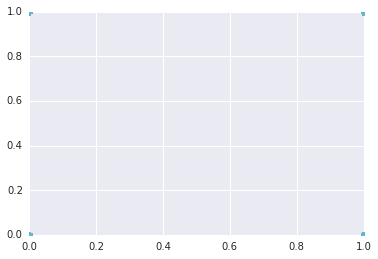

In [53]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cross_validation import cross_val_score, KFold, cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def cross_validate():
  scores = []

  fin = pd.read_csv("/users/chaitanya/PyCharmProjects/EventRec/newdata/train.csv")  # Open feature data
  X = np.matrix(pd.DataFrame(fin, index=None, columns=["invited", "user_reco", "event_p_reco","event_c_reco", 
                                                           "user_pop","friend_attend","friend_infl","event_pop",
                                                           "time_diff", "location_diff"]))
#   y = np.matrix(pd.DataFrame(fin, index=None, columns=["interested","not_interested"]))
  y = np.array(fin.interested)
    
#   sns.pairplot(fin, x_vars=["invited", "user_reco", "event_p_reco","event_c_reco","user_pop","friend_attend","friend_infl",
#                             "event_pop","time_diff", "location_diff"], y_vars='interested', size=6,kind='reg')  
    
# Models

  logreg = LogisticRegression()
  rf =  RandomForestClassifier(n_estimators=50)
  et = ExtraTreesClassifier(n_estimators=50)
  gb = GradientBoostingClassifier(n_estimators=10)
  clf = SGDClassifier(loss="log", penalty="l2")
    
    
#   print cross_val_score(rf, X, y, cv=15, scoring='accuracy').mean()

  skfold = StratifiedKFold(y, n_folds=11)  # Ideal maximum accuracy
  
  for train, test in skfold:
      xtrain, xtest, ytrain, ytest = X[train], X[test], y[train], y[test]
      
      clf = rf
      clf.fit(xtrain, ytrain)    
      ntest =  len(y)
      accuracy = 0
        
      scores.append(clf.score(xtest, ytest))

      yp = clf.predict(xtest)
     
      plt.plot(yp, ytest, 'o')
#     plt.plot(ytest, ytest, 'r-')

#     plt.xlabel("Predicted")
#     plt.ylabel("Observed")
        
#     print scores      
  
  print("CV Score is ", np.mean(scores))  
    


# def fit():
        

def main():
  cross_validate()   
if __name__ == "__main__":
  main()

In [44]:
# eventIndex = cPickle.load(open("/users/chaitanya/PyCharmProjects/EventRec/Models/PE_eventIndex.pkl", 'rb'))
# # j = eventIndex["2828969498"]
# userIndex = cPickle.load(open("/users/chaitanya/PyCharmProjects/EventRec/Models/PE_userIndex.pkl", 'rb'))
# # u=userIndex["545289514"]
# userEventScores = sio.mmread("/users/chaitanya/PyCharmProjects/EventRec/Models/PE_userEventScores").todense()
# # vs = userEventScores[:, j]
# # print vs[727]
# # # v=[[3,1,9],[0,6,7]]
# # # v[:,2]
# userSimMatrix = sio.mmread("/users/chaitanya/PyCharmProjects/EventRec/Models/US_userSimMatrix").todense()
# # for i in range(2034):
# #     if userSimMatrix[99, i]>-1:
# #         print userSimMatrix[5,i]
# for i in range(2034):        
#     if userSimMatrix[88,i]>0:
#         print userSimMatrix[88,i]

# i = userIndex["545289514"]
# j = eventIndex["926605391"]

# vs = userEventScores[:, j]  # All user scores for given eventId
# sims = userSimMatrix[i, :]  # User similarity scores for all users with given user

# prod = sims * vs  # Multiply above matrices to get product score -> one float value
# print prod[0, 0] 

# userFriends = sio.mmread("/users/chaitanya/PyCharmProjects/EventRec/Models/UF_userFriends").todense()
# nusers = (np.shape(userFriends))[1]
# for i in range(2034):
#     if userFriends[2000,i]>0:
#         print userFriends[2000,i]
# print (userFriends[5, :].sum(axis=0) / nusers)[0,0]
# fin = open("/users/chaitanya/Downloads/train.csv", 'rb')
# ln = 0
    
# for line in fin:                 # iterate over all user-event pairs in train.csv
#   ln += 1
    
#   if ln < 2:
#     continue
        
#   cols = line.strip().split(",")
#   userId = cols[0]
#   if "." in cols[3]:
#       print userId
# userIndex = cPickle.load(open("/users/chaitanya/PyCharmProjects/EventRec/Models/PE_userIndex.pkl", 'rb'))
# numFriends = sio.mmread("/users/chaitanya/PyCharmProjects/EventRec/Models/UF_numFriends")
# userFriends = sio.mmread("/users/chaitanya/PyCharmProjects/EventRec/Models/UF_userFriends").todense()
# i = userIndex["3406326706"]
# print userFriends[i, :]   # Calculates sum of all user-friend scores for this user/ no.of friends

# userA = ss.dok_matrix((2034, 2034)) 
# userA[1,2] = 3.242
# userA[13,34] = 1.0
# userA[231,22] = 3
# userA[22,1] = 12
# userA[1,5] = 40

# h = normalize(userA, norm="l1", axis=0, copy=False)

# sio.mmwrite("/users/chaitanya/PyCharmProjects/EventRec/test_matrix", h)
# k = sio.mmread("/users/chaitanya/PyCharmProjects/EventRec/test_matrix").toarray()
# print userA[1,2]



# import cPickle
# fin = open("/users/chaitanya/PyCharmProjects/EventRec/data/users.csv", 'rb')
# ln = 0

# userIndex = cPickle.load(open("/users/chaitanya/PyCharmProjects/EventRec/Models/PE_userIndex.pkl", 'rb'))
# userInfo = []
# for line in fin:

#   ln += 1  
#   if ln < 2:
#     continue

#   cols = line.strip().split(",")
#   if cols[0] in userIndex:
#       userInfo.append([cols[0],cols[5]])

# print userInfo
# cPickle.dump(userInfo, open("/users/chaitanya/PyCharmProjects/EventRec/Models/UserInfo.pkl", 'wb'))

from sklearn.cross_validation import KFold
import numpy as np

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])
kf = KFold(4, n_folds=4)

for train, test in kf:
    print("TRAIN:", train_index, "TEST:", test_index)
    Xtrain, Xtest, ytrain, ytest = X[train], X[test], y[train], y[test]
    print Xtrain, Xtest,ytrain, ytest


('TRAIN:', array([1, 2, 3]), 'TEST:', array([0]))
[[3 4]
 [1 2]
 [3 4]] [[1 2]] [2 3 4] [1]
('TRAIN:', array([1, 2, 3]), 'TEST:', array([0]))
[[1 2]
 [1 2]
 [3 4]] [[3 4]] [1 3 4] [2]
('TRAIN:', array([1, 2, 3]), 'TEST:', array([0]))
[[1 2]
 [3 4]
 [3 4]] [[1 2]] [1 2 4] [3]
('TRAIN:', array([1, 2, 3]), 'TEST:', array([0]))
[[1 2]
 [3 4]
 [1 2]] [[3 4]] [1 2 3] [4]


In [40]:
eventCountry = ""
eventCity = ""
userLocation = ""
eventInfo = cPickle.load(open("/users/chaitanya/PyCharmProjects/EventRec/Models/EventInfo.pkl", 'rb'))
userInfo = cPickle.load(open("/users/chaitanya/PyCharmProjects/EventRec/Models/UserInfo.pkl", 'rb'))

ln=0
fin = open("/users/chaitanya/PyCharmProjects/EventRec/data/train.csv", 'rb')

for line in fin:                 # iterate over all user-event pairs in train.csv
    ln += 1
    
    if ln < 2:
      continue
       
    cols = line.strip().split(",")

    for event in eventInfo:  
      if event[0] == cols[1]: 
        eventCity = event[2]
        eventCountry = event[3]
    
    for user in userInfo:
      if user[0] == cols[0]:
        userLocation = user[1]
        
    if (userLocation!="") and (eventCity!="" or eventCountry!=""):
        if eventCity in userLocation:       # user is in the city of the event

            print 1
        elif eventCountry in userLocation:  # user is in the country of the event

            print 0.5
        else:                               # If user is not in country of event, location feature=>0
            print 0
    
    

0
0
0
0
Mauritius Beau Vallon  Grand Port  Mauritius
0.5
0
Tangerang Tangerang
1
Tangerang Tangerang
1
Medan Medan  Indonesia
1
Medan Medan  Indonesia
1
Medan Medan  Indonesia
1
Yogyakarta Yogyakarta  Indonesia
1
Indonesia Yogyakarta  Indonesia
0.5
Indonesia Yogyakarta  Indonesia
0.5
Medan Medan  Indonesia
1
Medan Medan  Indonesia
1
Bekasi Bekasi
1
Bekasi Bekasi
1
0
0
0
0
0
0
0
Indonesia Medan  Indonesia
0.5
Medan Medan  Indonesia
1
Medan Medan  Indonesia
1
Indonesia Medan  Indonesia
0.5
Indonesia Medan  Indonesia
0.5
Indonesia Medan  Indonesia
0.5
Medan Medan  Indonesia
1
Medan Medan  Indonesia
1
Medan Medan  Indonesia
1
Indonesia Medan  Indonesia
0.5
Indonesia Medan  Indonesia
0.5
Indonesia Medan  Indonesia
0.5
Indonesia Lahat  Sumatera Selatan  Indonesia
0.5
Medan Medan  Indonesia
1
Medan Medan  Indonesia
1
Medan Medan  Indonesia
1
Medan Medan  Indonesia
1
Yogyakarta Yogyakarta  Indonesia
1
0
0
0
0
0
0
0
Indonesia Yogyakarta  Indonesia
0.5
Medan Medan  Indonesia
1
Medan Medan  Indon

In [37]:
plt.plot(yp, ytest, 'o')


NameError: name 'yp' is not defined